This document is meant to start seeing what happens if we change the privacy budget of the adaSSP algorithm from https://arxiv.org/pdf/1803.02596.pdf. Can we get better performance for ridge regression in this differentially private setting?

The data here is from the github https://github.com/yuxiangw/optimal_dp_linear_regression of the previously mentioned paper.

In [1]:
import pandas as pd
import numpy as np
from numpy import linalg as LA
from numpy.random import normal
from numpy import sqrt, log
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


In [2]:
# bring in the data
mat_input = loadmat('data/bike/bike.mat')['data']
bike_df = pd.DataFrame(data=mat_input)

# process the X and y
bike_shape = bike_df.shape
X_df = bike_df.drop(bike_shape[1]-1,axis=1)
# make sure that ||X||_2^2 = 1
sum_squares = X_df.apply(lambda x: x**2).sum().sum()
X_df = X_df.apply(lambda x: x / sqrt(sum_squares))

# divide out by max
y_df = bike_df[bike_shape[1]-1]
y_df = y_df / abs(y_df.max())

Define SSP and the adaptive variant, adaSSP.
In adaSSP, introduce the $\gamma$ variable, where $\gamma \in [0,1]$ and $\gamma$ represents the proportion of the privacy budget going towards the private release of the minimum eigenvalue.

In [3]:

#print(SSP(X_df, y_df, 0.1, delta=10 ** (-6)))

In [4]:
# define adaSSP
def adaSSP(X_df,y_df,epsilon,delta,gamma):
    """
    # gamma is a number in [0,1], says how much budget to put in getting the hyperparameter
    """
    assert(gamma <= 1 and gamma >= 0)
    BX = 1
    BY = 1
    varrho =0.05
    [n,d] = X_df.shape
    X = X_df.values
    y = y_df.values
        
    epsilon_hyper = gamma * epsilon
    delta_hyper = gamma * delta
    # divide by 2 because we want all portions to add to 100%
    epsilon_necessary = (1. - gamma) * epsilon / 2.0
    delta_necessary = (1. - gamma) * delta / 2.0
    # handle the hyperparameter business (dealing with minimum eigenvalue)
    
    logsod_hyper = np.log(2./delta_hyper)
    eta = sqrt(d*logsod_hyper*log(2*d*d/varrho))*BX*BX/(epsilon_hyper)
    XTy = X.T.dot(y)
    # why does Wang add this identity matrix?
    XTX = (X.T).dot(X) + np.eye(d)
    w = LA.eigvals(XTX)
    lambda_min_true = min(w)
    
    lamb_min = lambda_min_true + normal(0., 1., 1)*BX*BX*np.sqrt(logsod_hyper)/(epsilon_hyper) - logsod_hyper/(epsilon_hyper)
    lamb_min = max(lamb_min, 0.)

    
    # then handle the "necessary" parts of linear regression
    logsod_necessary = np.log(2./delta_necessary)
    # for X^Ty
    normal_vec = normal(0.0,1.0,d)
    normal_vec_scalar = (sqrt(logsod_necessary)/(epsilon_necessary))*BX*BY
    XTy_hat = XTy + normal_vec_scalar * normal_vec
    
    # for X^TX
    normal_mat = normal(0.0,1.0,(d,d))
    symmetric_normal_mat = 0.5 * (normal_mat + normal_mat.T)
    XTX_hat = XTX + (sqrt(logsod_necessary)/(epsilon_necessary))*BX*BX*symmetric_normal_mat
    
    # the new version of (X^TX + lambda*I)^{-1}(X^Ty)
    theta_hat = LA.inv(XTX_hat + lamb_min * np.eye(d)).dot(XTy_hat)
    
    return theta_hat
#print(adaSSP(X_df, y_df, 0.1, delta=10 ** (-6), gamma=1./3.))
    

Now let's see what happens if we change epsilon (and gamma).

In [5]:
# this function plots MSE vs. Epsilon (or Gamma), with multiple lines for different Gamma (or Epsilon)
def multiple_error_plots(list1,list2, name1, name2, list1_is_epsilon=True, num_trials=10):
    """
    list1 will be the different colored lines
    list2 will be what is on the x-axis
    name1 and name2 are the names for these quantities (ex. 'Epsilon')
    """
    
    val1_error_means = []
    val1_error_stds = []
    for val1 in list1:
        error_means = []
        error_stds = []
        for val2 in list2:
            val2_errors = []
            for i in range(num_trials):
                X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.1)
                try:
                    if list1_is_epsilon:
                        theta_hat = adaSSP(X_train, y_train, epsilon=val1, delta=10 ** (-6), gamma=val2)
                    else:
                        theta_hat = adaSSP(X_train, y_train, epsilon=val2, delta=10 ** (-6), gamma=val1)
                    # then see how it does with the predictions on test set
                    y_pred = (X_test.values).dot(theta_hat)
                    err = mean_squared_error(y_pred, y_test)
                    val2_errors.append(err)
                except:
                    print("Some kind of error happened, likely had a complex solution")
            error_means.append(np.mean(val2_errors))
            error_stds.append(np.std(val2_errors))
        val1_error_means.append(error_means)
        val1_error_stds.append(error_stds)

        plt.errorbar(list2, error_means, yerr=error_stds, label=f"{name1} = {val1:.4f}")
    plt.yscale('log')
    if not list1_is_epsilon:
        plt.xscale('log')
    plt.xlabel(name2)
    plt.ylabel('Test Prediction MSE')
    plt.title(f'ADASSP Performance vs. {name2} for Different {name1} Values')
    plt.legend()
    plt.show()


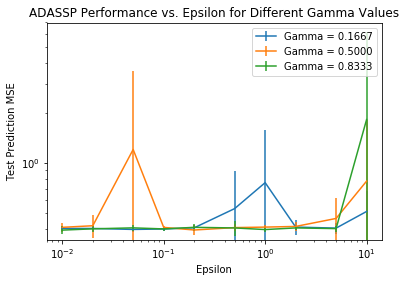

In [6]:
epsilon_list = [0.01,0.02,0.05,0.1,0.2,0.5,1,2,5,10]
gamma_list = [1.0/6.0, 2.0/6.0, 3.0/6.0, 4.0/6.0, 5.0/6.0]
# epsilon on x-axis
multiple_error_plots(list1=[1.0/6.0,1.0/2.0,5.0/6.0], list2=epsilon_list, name1="Gamma", name2="Epsilon", list1_is_epsilon=False, num_trials=10)

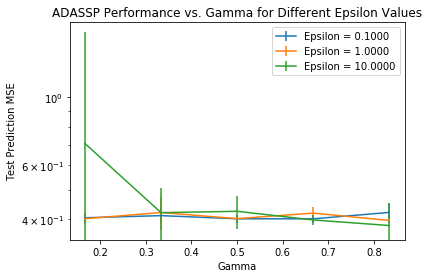

In [7]:
# gamma on x-axis
multiple_error_plots(list1=[0.1,1.0,10.0], list2=gamma_list, name1="Epsilon", name2="Gamma", list1_is_epsilon=True, num_trials=10)

Text(0.5, 1.0, 'SSP MSE vs. Epsilon')

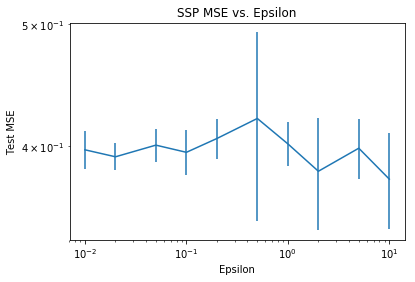

In [8]:
# show a graph for the standard SSP (plot over different epsilons)
epsilon_list = [0.01,0.02,0.05,0.1,0.2,0.5,1,2,5,10]
error_means = []
error_stds = []
num_trials = 10
for epsilon in epsilon_list:
    epsilon_errors = []
    for i in range(num_trials):
        X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.1)
        theta_hat = SSP(X_train, y_train, epsilon=epsilon, delta=10 ** (-6))
        # then see how it does with the predictions on test set
        y_pred = (X_test.values).dot(theta_hat)
        err = mean_squared_error(y_pred, y_test)
        epsilon_errors.append(err)

    error_means.append(np.mean(epsilon_errors))
    error_stds.append(np.std(epsilon_errors))

plt.errorbar(epsilon_list, error_means, yerr=error_stds)
plt.yscale('log')
plt.xscale('log')
plt.ylabel("Test MSE")
plt.xlabel("Epsilon")
plt.title("SSP MSE vs. Epsilon")